
# Import Packages

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
import tensorflow as tf

In [19]:
sys.path.append(os.path.abspath(os.path.join('../../..')))
from bayesflow.forward_inference import Prior, Simulator, GenerativeModel
from bayesflow.networks import InvertibleNetwork
from bayesflow.amortized_inference import AmortizedPosterior
from bayesflow.trainers import Trainer
import bayesflow.diagnostics as diag

# Introduction
<br>
In this tutorial, we will look at a simple linear ODE system:

<br><br>
$$
\frac{du}{dt} = a u + b v \\
\frac{dv}{dt} = c u + d v  
$$
<br><br>


with the boundary conditions:

<br><br>
$$
u(t=0) = u_0 \\
v(t=0) = v_0
$$
<br><br>

Given the solutions $u(t)$ and $v(t)$, we want to use BayesFlow to predict the parameters $a$, $b$, $c$ and $d$ of the ODE equations as well as the boundary conditions $u_0$ and $v_0$.  


# Analytical Solution

The advantage of such a simple ODE system is, that the analytical solutions for $u$ and $v$ are known:

<br><br>
$$
\begin{pmatrix}
    u \\
    v
\end{pmatrix}
= C_1 e^{\lambda_1 t} \vec{v_1} + C_2 e^{\lambda_2 t} \vec{v_2} = 
\begin{bmatrix}
    \vec{v_1} & \vec{v_2}
\end{bmatrix}
\begin{pmatrix}
    C_1 e^{\lambda_1 t} \\
    C_2 e^{\lambda_2 t}
\end{pmatrix}
$$
<br><br>

where $\lambda_1$ and $\lambda_2$ are eigenvalues and $\vec{v_1}$ and $\vec{v_2}$ are eigenvectors of the matrix:

<br><br>
$$
A=
\begin{pmatrix}
    a & b \\
    c & d \\
\end{pmatrix}
$$
<br><br>

$\begin{bmatrix} \vec{v_1} & \vec{v_2} \end{bmatrix}$ is the matrix, that has the eigenvectors $\vec{v_1}$ and $\vec{v_2}$ as its column vectors. 

<br><br>
The constants $C_1$ and $C_2$ can be computed from the boundary condition:

<br><br>
$$
\begin{pmatrix}
    C_1 \\
    C_2
\end{pmatrix}
=
\begin{bmatrix}
    \vec{v_1} & \vec{v_2}
\end{bmatrix}^{-1}
\begin{pmatrix}
    u_0 \\
    v_0
\end{pmatrix}
$$

# Stability of Solutions

The solution $u$ and $v$ will be of the form:

<br><br>
$$
u = v_{11} C_1 e^{\lambda_1 t} + v_{21} C_2 e^{\lambda_2 t} \\
v = v_{12} C_1 e^{\lambda_1 t} + v_{22} C_2 e^{\lambda_2 t}
$$
<br><br>

By separating the real and complex part of the eigenvalues $\lambda_i = \gamma + i \omega$ we see, that the real part affects if a solution will be exponential increasing/decreasing or stay constant, whereas the complex part will determine the oscillation behaviour. 

<br><br>
$$
u = v_{11} C_1 e^{\gamma_1 t} \left[ cos(\omega_1 t) + i sin(\omega_1 t) \right] + v_{21} C_2 e^{\gamma_2 t} \left[ cos(\omega_2 t) + i sin(\omega_2 t) \right] \\
v = v_{12} C_1 e^{\gamma_1 t} \left[ cos(\omega_1 t) + i sin(\omega_1 t) \right] + v_{22} C_2 e^{\gamma_2 t} \left[  cos(\omega_2 t) + i sin(\omega_2 t) \right]
$$
<br><br>

We will apply rejection sampling to only consider stable solutions, in other words solution that fulfill the condition $\gamma_1 \leq 0$ and $\gamma_2 \leq 0$.  

 # Generate Simulation Data with Rejection Sampling
 
We have to generate some simulation data to train our BayesFlow. The first step is to randomly draw combinations of $a$, $b$, $c$, $d$, $u_0$ and $v_0$ from a uniform prior distribution. Additionally, we estimate the prior means and standard deviations for normalization later.  

In [3]:
def model_prior():
    """Generates random draws from uniform pior with rejection sampling"""
    
    while True:
        # generate sample
        samples = np.random.uniform(low=-10, high=10, size=6)
        
        # reject, if solution not stable
        A = samples[:4].reshape((2, 2))
        eigenvalues, _ = np.linalg.eig(A)
        if eigenvalues[0].real <= 0 and eigenvalues[1].real <= 0:
            break
            
    return samples   

In [4]:
prior = Prior(prior_fun=model_prior, param_names=[r'$a$', r'$b$', r'$c$', r'$d$', r'$u_0$', r'$v_0$']) 
prior_means, prior_stds = prior.estimate_means_and_stds()

The next step is to generate simulation data from the prior samples by defining a simulator:

In [5]:
def linear_ode_solver(params, t):
    """Solves the linear ODE system analytically for given time points t and prior parameter samples"""
    
    # unpack params
    A = params[:4].reshape((2, 2))
    boundaries = params[-2:]
    
    # solve for u and v
    eigenvalues, eigenvectors = np.linalg.eig(A)
    C = np.linalg.inv(eigenvectors) @ boundaries
    solution = eigenvectors @ np.array([C[0] * np.exp(eigenvalues[0] * t), C[1] * np.exp(eigenvalues[1] * t)])
    
    return solution[0], solution[1]

In [6]:
time_points = np.linspace(0, 5, num=64)
simulator = Simulator(simulator_fun=partial(linear_ode_solver, t=time_points))

Finally, we will wrap the prior and simulator into a generative model for simuation data generation:

In [7]:
model = GenerativeModel(prior, simulator, name='linear_ODE_generator')

INFO:root:Performing 2 pilot runs with the linear_ODE_generator model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 6)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 2, 64)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


As a sanity check, we will sample 1000 prior combinations and visualize the joint priors in bivariate plots. Note that we have applied rejection sampling. Therefore, certain combinations of $a$, $b$, $c$, $d$ will always be rejected, because they will produce unstable solutions.  

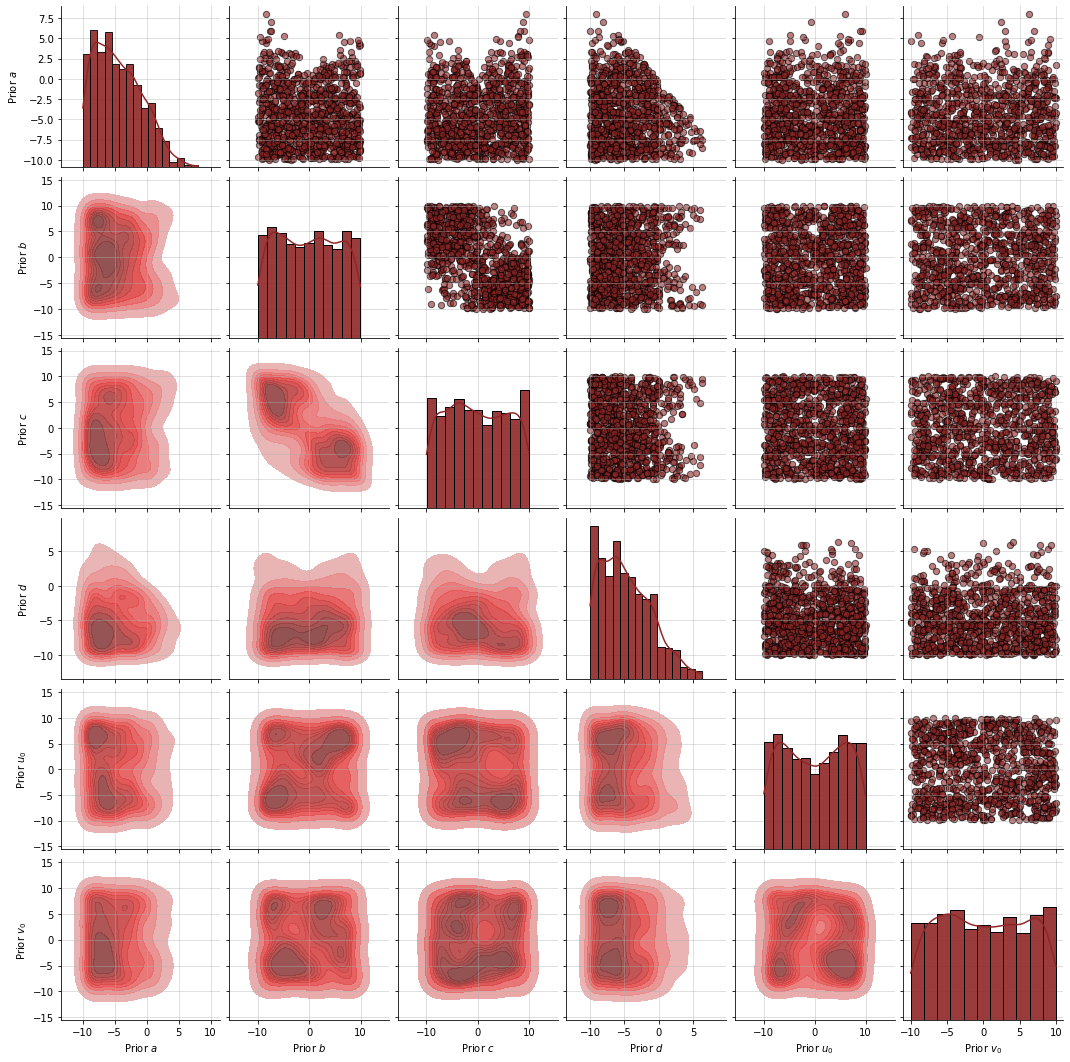

In [8]:
fig = prior.plot_prior2d()

Additionally, we can visualize the simulation data:

/home/leo/.local/share/virtualenvs/BayesFlow-sDCF3KYj/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


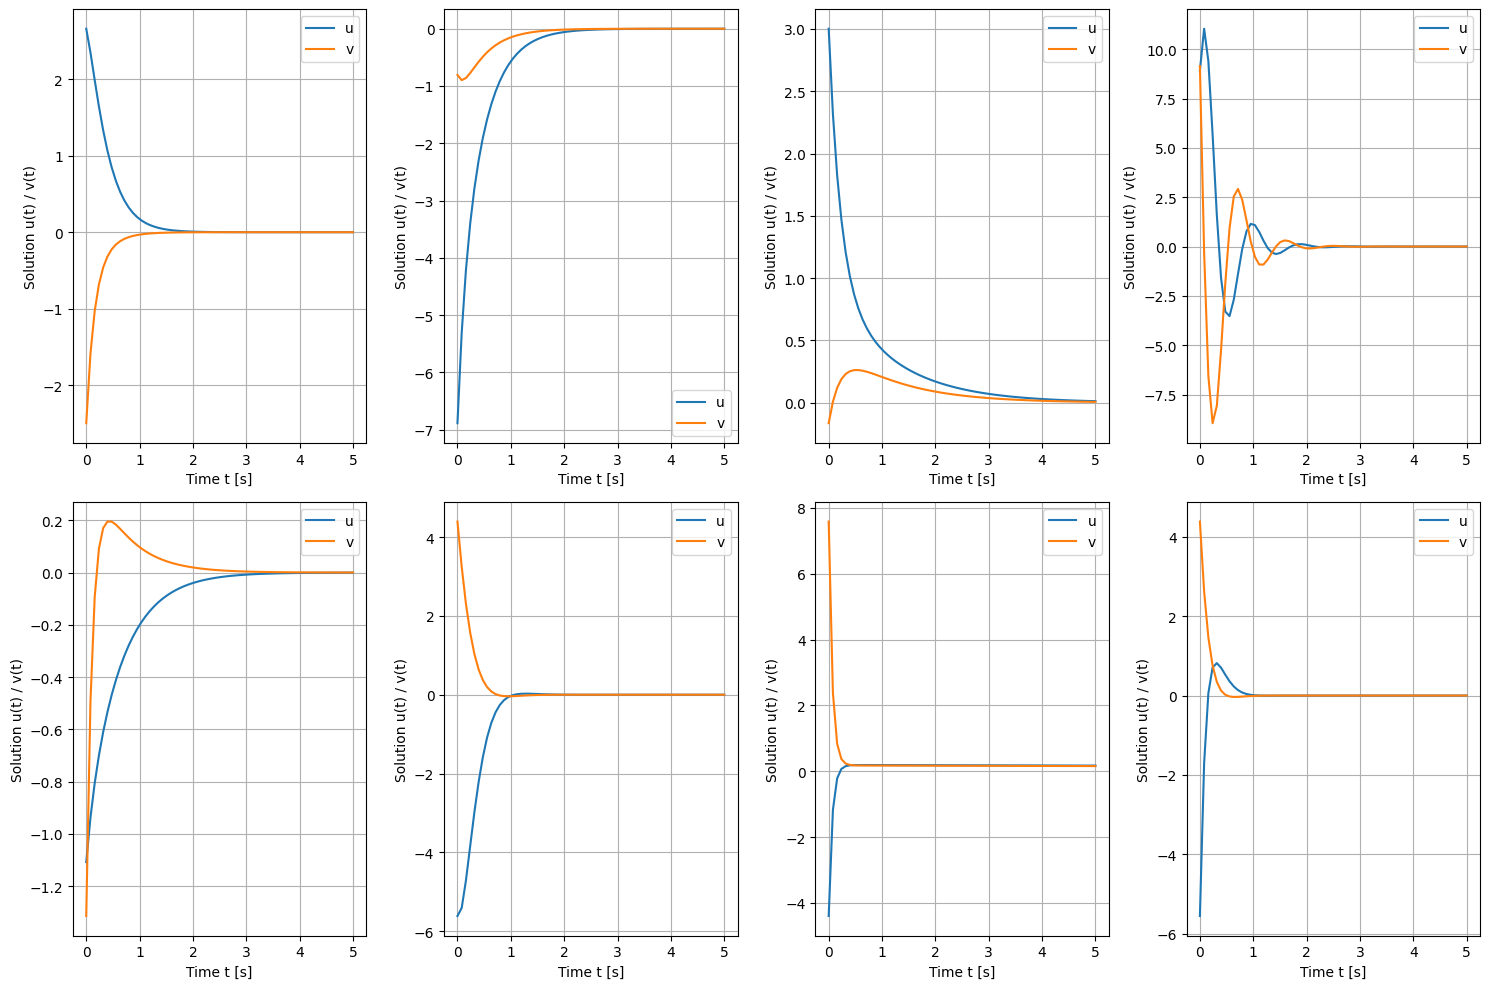

In [9]:
sim_data = model(8)['sim_data']
fig, ax = plt.subplots(2, 4, figsize=(15, 10))
ax = ax.flat

for i, data in enumerate(sim_data):
    ax[i].plot(time_points, data[0, :], label='u')
    ax[i].plot(time_points, data[1, :], label='v')
    ax[i].set_xlabel("Time t [s]")
    ax[i].set_ylabel("Solution u(t) / v(t)")
    ax[i].grid(True)
    ax[i].legend()

plt.tight_layout()
plt.show()

# BayesFlow architecture

The BayesFlow architecture consists of a summary network and an invertible neural network. The summary network learns summary statistics for each input, such that the summary network output will have dimension (batch_size, summary_dim). The invertible neural network is conditioned on the summary statistic. For this tutorial, we will use a small LSTM summary network:

In [10]:
class LSTM(tf.keras.Model):
    def __init__(self, summary_dim=64):
        super(LSTM, self).__init__()
        
        self.LSTM = tf.keras.Sequential([
            tf.keras.layers.LSTM(summary_dim, return_sequences=True),
            tf.keras.layers.LSTM(summary_dim, return_sequences=True),
            tf.keras.layers.LSTM(summary_dim)
        ])
    
    def call(self, x, **kwargs):
        out = self.LSTM(x)
        return out

In [11]:
summary_net = LSTM()

2022-07-26 16:10:28.940501: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-26 16:10:28.949580: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-26 16:10:28.950529: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-26 16:10:28.953552: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

For the inference network, we will use a small 4-layer cINN:

In [12]:
inference_net = InvertibleNetwork({
    'n_params' : 6,
    'n_coupling_layers' : 4,
})

Finally, we wrap the summary network and inference network into an AmortizedPosterior instance:

In [13]:
amortizer = AmortizedPosterior(inference_net, summary_net, name='linear_ODE_amortizer')

# Preproccessing

Before we feed the simulation data to our BayesFlow amortizer, we want to perform some preprocessing such as normalization, logscale conversion for stability and removing nan/infinite samples.

In [14]:
def preprocessing(forward_dict):
    out_dict = {}
    
    # convert to logscale
    log_data = np.log1p(forward_dict['sim_data']).astype(np.float32)
    
    # normalization
    params = forward_dict['prior_draws'].astype(np.float32)
    norm_params = (params - prior_means) / prior_stds
    
    # remove nan, inf and -inf
    keep_idx = np.all(np.isfinite(log_data), axis=(1, 2))
    if not np.all(keep_idx):
        print('Invalid value encountered...removing from batch')
        
    # add to dict
    out_dict['summary_conditions'] = log_data[keep_idx]
    out_dict['parameters'] = params[keep_idx]
    
    return out_dict

# Training

To train our BayesFlow amortizer, we first have to define a Trainer instance:

In [15]:
trainer = Trainer(
    amortizer=amortizer,
    generative_model=model,
    configurator=preprocessing
)

INFO:root:Performing a consistency check with provided components...
/tmp/ipykernel_13798/4082411197.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  log_data = np.log1p(forward_dict['sim_data']).astype(np.float32)
2022-07-26 16:10:30.746991: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
INFO:root:Done.


Once we initialized the Trainer instance and run a consistency check on a test batch, we can print the number of trainable and non-trainable parameters in our BayesFlow model:

In [16]:
amortizer.summary()

Model: "linear_ODE_amortizer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 invertible_network (Inverti  multiple                 139408    
 bleNetwork)                                                     
                                                                 
 lstm (LSTM)                 multiple                  99072     
                                                                 
Total params: 238,480
Trainable params: 238,432
Non-trainable params: 48
_________________________________________________________________


Now, we can train our BayesFlow model online:

In [18]:
losses = trainer.train_online(epochs=10, iterations_per_epoch=100, batch_size=32)

Training epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]

/tmp/ipykernel_13798/4082411197.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  log_data = np.log1p(forward_dict['sim_data']).astype(np.float32)


Training epoch 2:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/100 [00:00<?, ?it/s]

We can visualize the training loss to inspect, if the training has converge.

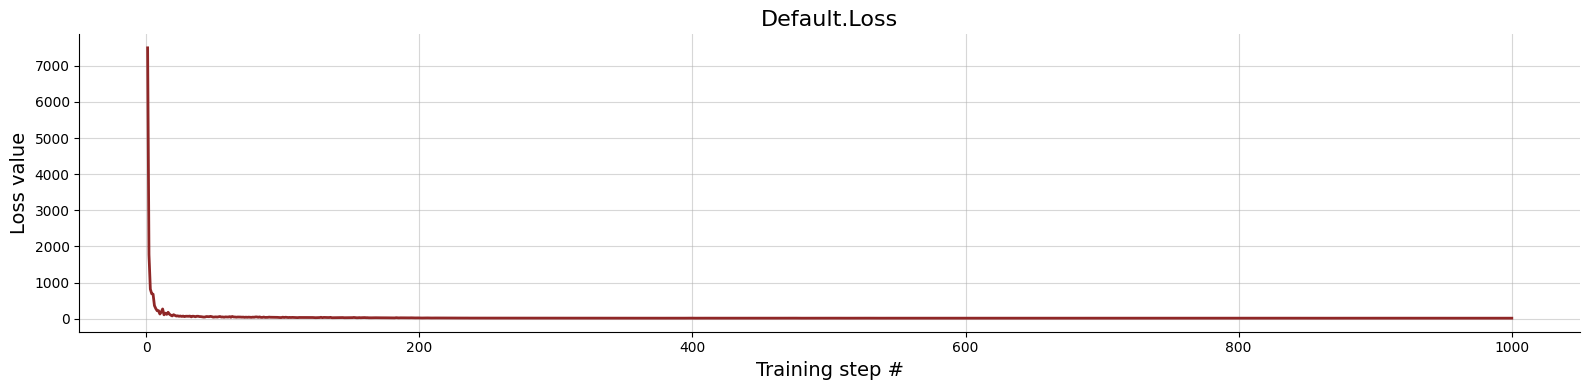

In [20]:
fig = diag.plot_losses(losses)

# Validating the results

After training BayesFlow, we want to validate the results. One first step is to inspect the latent space $z$, which by training we enforce to be Gaussian using Kullback-Leibler (KL) loss.  

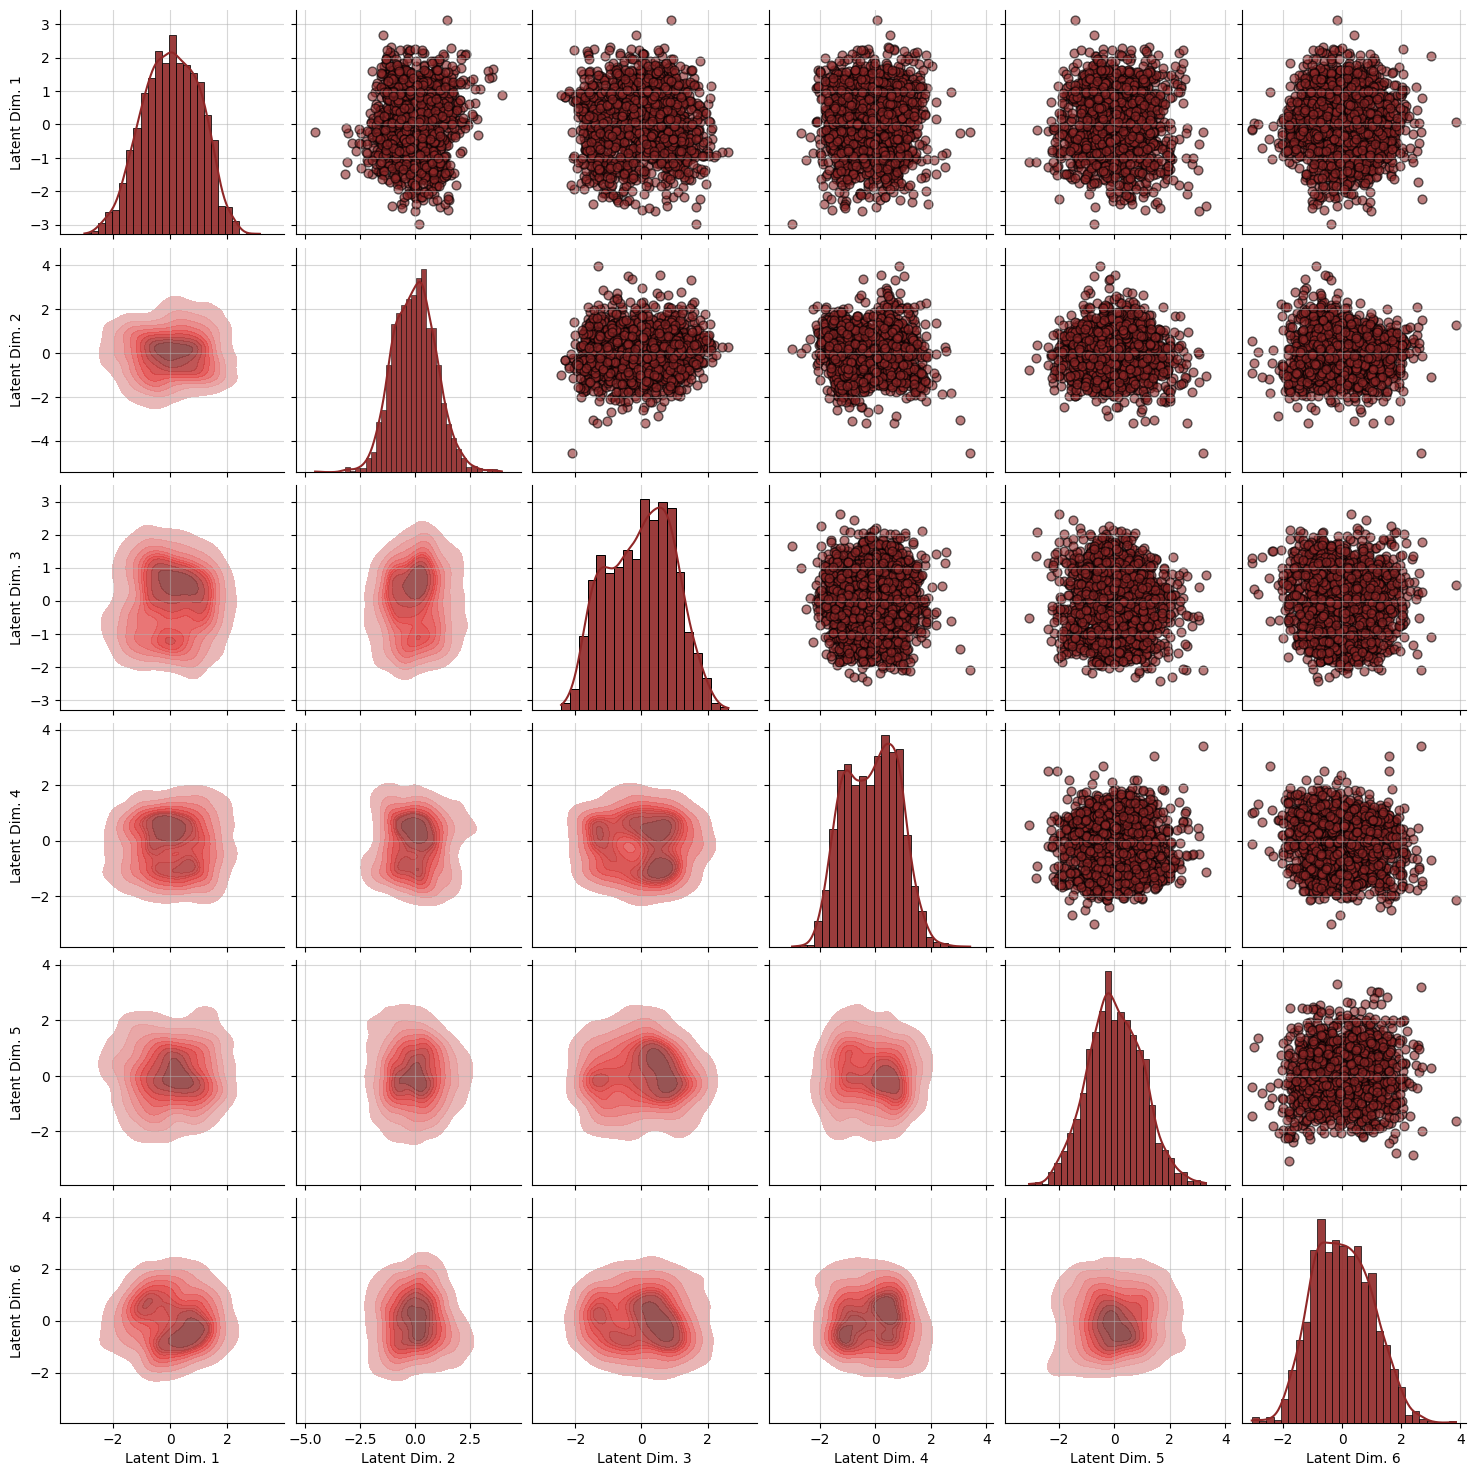

In [21]:
fig = trainer.diagnose_latent2d()